In [1]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [2]:
from utils import import_data, compute_KNN_graph, create_graph, create_batch,reconstruct_symmetric_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from neurocombat_sklearn import CombatModel

torch.set_default_dtype(torch.float64)
np.random.seed(3)

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
          'f1' : 'f1_macro',
          'roc_auc' : 'roc_auc'}


In [3]:
df, phenotypic = import_data(fisher=False)

#df = df.join(pd.DataFrame(phenotypic.Age), how='left')
#df = df.join(pd.DataFrame(phenotypic['ADHD Measure']), how='left')
df = df.join(pd.DataFrame(phenotypic['Gender']), how='left')

df['Age'] = phenotypic['Age']

df = df.reset_index()
df = df.dropna(axis=0)
df['Site'] = df['Institution'].astype('category')
df['Site'] = df['Site'].cat.codes

from sklearn.utils import shuffle
df = shuffle(df, random_state=42)


#X = df.drop(columns=['Institution', 'Run', 'Age','ADHD Measure', 'Gender', 'Subject'])
y = df.Gender.astype(int)

In [4]:
df_train = df[~df.Subject.isin(np.random.choice(df['Subject'].unique(),100))]
df_test = df[df.Subject.isin(np.random.choice(df['Subject'].unique(),100))]

Age_train = df_train[['Age']]
Site_train = df_train[['Site']]
X_train = df_train.drop(columns=['Institution', 'Subject', 'Run','Gender', 'Age', 'Site'])
y_train = df_train.Gender

Age_test = df_test[['Age']]
Site_test = df_test[['Site']]
X_test = df_test.drop(columns=['Institution', 'Subject', 'Run', 'Gender', 'Age', 'Site'])
y_test = df_test.Gender

In [5]:

# Creating model
model = CombatModel()

# Fitting the model and transforming the training set
X_train = model.fit_transform(X_train.values,
                                         Site_train) #X_train_har

# Harmonize test set using training set fitted parameters
X_test = model.transform(X_test.values,
                                    Site_test) #X_test_har

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [61]:
img_train = np.zeros((X_train.shape[0],1, 190, 190))
for i in range(X_train.shape[0]):
    img_train[i, :, :] = reconstruct_symmetric_matrix(190,X_train[i,:])
    
img_test = np.zeros((X_test.shape[0], 1, 190, 190))
for i in range(X_test.shape[0]):
    img_test[i, :, :] = reconstruct_symmetric_matrix(190,X_test[i,:])

In [62]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as func

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None, target_transform=None):
        self.images = torch.from_numpy(images)
        self.img_labels = torch.from_numpy(labels.values.astype(int))
        self.transform = transform
        self.target_transform = target_transform
        # self.transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize((0.5,), (0.5,))
        # ])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        #image = self.transform(image)
        label = self.img_labels[idx]
        return image,label

img_train = ImageDataset(img_train, y_train)
train_loader = DataLoader(img_train, batch_size=32)

img_test = ImageDataset(img_test, y_test)
test_loader = DataLoader(img_test, batch_size=32)


In [63]:
len(img_train)

2062

In [64]:
xs, ys = img_train[0:4]
print(xs.shape)

torch.Size([4, 1, 190, 190])


In [65]:
# With square kernels and equal stride
m = nn.Conv2d(1, 33, 3, stride=2)
n = nn.ReLU()

In [66]:
print('Images .shape \n', xs.shape)
print('Images after CNN .shape \n',m(xs).shape)
print('Images after CNN -> ReLU .shape \n', n(m(xs)).shape)

Images .shape 
 torch.Size([4, 1, 190, 190])
Images after CNN .shape 
 torch.Size([4, 33, 94, 94])
Images after CNN -> ReLU .shape 
 torch.Size([4, 33, 94, 94])


In [72]:
class NN(nn.Module):
    def __init__(self,dropout=.3):
        super(NN,self).__init__()
        
        self.conv1 = nn.Conv2d(1, 12, kernel_size=(4,4), stride=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(12, 16, kernel_size=(4,4), stride=1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=(4,4), stride=1)
        self.pool3 = nn.MaxPool2d(2,2)
        
        self.lin1 = nn.Linear(3528, 2)
        self.R = nn.ReLU()
        self.p = dropout
        
    def forward(self,x):
        x = self.R(self.conv1(x))
        x = self.R(self.pool1(x))
        x = func.dropout(x, p=self.p, training=self.training)
        x = self.R(self.conv2(x))
        x = self.R(self.pool2(x))
        x = func.dropout(x, p=self.p, training=self.training)
        x = self.R(self.conv3(x))
        x = self.R(self.pool3(x))
        #x = x.view(-1,4*(46**2))
        x = torch.flatten(x,1)
        x = self.lin1(x)
        return x.squeeze()

In [73]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [74]:
f = NN()
count_parameters(f)

12406

In [75]:
xs.shape

torch.Size([4, 1, 190, 190])

In [76]:
f(xs).shape

torch.Size([4, 2])

In [77]:
# for batch, (X, y) in enumerate(train_loader):
#     print(X)

Feature batch shape: torch.Size([32, 1, 190, 190])
Labels batch shape: torch.Size([32])


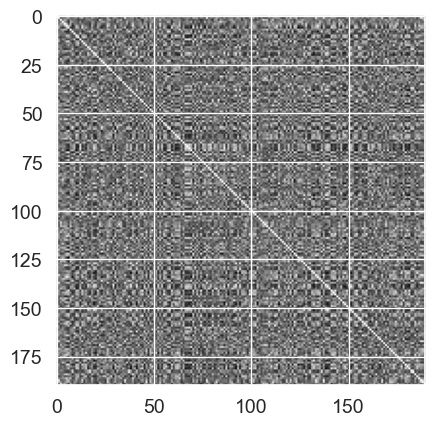

Label: 0


In [78]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")


In [79]:
from torch.autograd import Variable

def train_loop(dataloader, model, optimizer, L, loop):
    size = len(dataloader.dataset)
    model.train()
    loss_all = 0
    
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    for batch, (X, y) in enumerate(loop):
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        y = y.to(device)
        # Compute prediction and loss
        output = model(X)
        #print(output.shape)
        loss = L(output, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_all += loss.item()*len(y)
        
        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss_all/len(img_train))

        # if batch % 100 == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, L):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += L(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

L = nn.CrossEntropyLoss()

NUM_EPOCHS = 25
for epoch in range(1,NUM_EPOCHS + 1):
    loop = tqdm(train_loader)
    train_loop(train_loader, model, optimizer, L, loop)
    test_loop(test_loader, model, L)

Epoch [1/25]: 100%|█████████████████| 65/65 [00:29<00:00,  2.20it/s, loss=0.716]


Test Error: 
 Accuracy: 66.7%, Avg loss: 0.644618 



Epoch [2/25]: 100%|█████████████████| 65/65 [01:05<00:00,  1.00s/it, loss=0.676]


Test Error: 
 Accuracy: 66.7%, Avg loss: 0.644324 



Epoch [3/25]:   6%|█                | 4/65 [00:17<04:28,  4.40s/it, loss=0.0423]


KeyboardInterrupt: 